In [103]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import trim_mean
sns.set_style("whitegrid")

In [51]:
df = pd.read_csv("files/data.csv")

In [52]:
not_important = ['id','uri','track_href','analysis_url','duration_ms','type']
dfc = df.drop(columns=not_important)

In [53]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre             5000 non-null   object 
 1   Popularity        5000 non-null   float64
 2   Song              5000 non-null   object 
 3   danceability      5000 non-null   float64
 4   energy            5000 non-null   float64
 5   key               5000 non-null   object 
 6   loudness          5000 non-null   float64
 7   mode              5000 non-null   object 
 8   speechiness       5000 non-null   float64
 9   acousticness      5000 non-null   float64
 10  instrumentalness  5000 non-null   float64
 11  liveness          5000 non-null   float64
 12  valence           5000 non-null   float64
 13  tempo             5000 non-null   float64
 14  time_signature    5000 non-null   object 
 15  seconds           5000 non-null   float64
dtypes: float64(11), object(5)
memory usage: 62

In [69]:
numeric_cols = dfc.select_dtypes('number').columns
target = 'energy'

# Estimates of location

In [70]:
# Mean
df.groupby("genre")[target].mean()

genre
chill        0.519152
garage       0.707677
hard-rock    0.767888
indie-pop    0.565869
pop          0.626116
Name: energy, dtype: float64

In [71]:
# Trimmed mean -> Drop fixed quantity at the bottom and top end (sorted values) -> More robust. -> Compromise between median and mean.
df.groupby("genre")[target].apply(lambda x : trim_mean(x,0.1))

genre
chill        0.523231
garage       0.721370
hard-rock    0.786287
indie-pop    0.568971
pop          0.634767
Name: energy, dtype: float64

In [80]:
# Weighted mean -> Some groups are more variable than others.-> Highly variable observations are given lower weight.
df.groupby("genre").apply(lambda x : np.average(x[target],weights=x['valence']))

genre
chill        0.543170
garage       0.725381
hard-rock    0.770452
indie-pop    0.610458
pop          0.673097
dtype: float64

In [81]:
# Median -> Value at the middle, not influenced by outliers.
df.groupby("genre")[target].median()

genre
chill        0.5305
garage       0.7410
hard-rock    0.8075
indie-pop    0.5700
pop          0.6485
Name: energy, dtype: float64

# Estimation of variability

In [83]:
df.groupby("genre")[target].std() # Original scale of data

genre
chill        0.234549
garage       0.186465
hard-rock    0.171366
indie-pop    0.211286
pop          0.181100
Name: energy, dtype: float64

In [88]:
df.groupby("genre")[target].var() # Variance

genre
chill        0.055013
garage       0.034769
hard-rock    0.029366
indie-pop    0.044642
pop          0.032797
Name: energy, dtype: float64

In [98]:
# Median absolute deviation
def median_absolute_deviation(x:pd.Series)->float:
    """Median absolute deviation of a series x"""
    m = x.median()
    s = (x - m).abs().median()
    return s
df.groupby("genre")[target].apply(lambda x : median_absolute_deviation(x)) # Variance

genre
chill        0.1730
garage       0.1355
hard-rock    0.1175
indie-pop    0.1620
pop          0.1305
Name: energy, dtype: float64

In [91]:
# Order statistics
# IQR
IQR = df.groupby("genre")[target].quantile(0.75) - df.groupby("genre")[target].quantile(0.25)
IQR

genre
chill        0.34375
garage       0.27025
hard-rock    0.25100
indie-pop    0.32700
pop          0.26100
Name: energy, dtype: float64

# DATA DISTRIBUTION

In [102]:
garage = df[df['genre']=='garage'][target]
garage.quantile([0.05,0.25,0.5,0.75,0.95])

0.05    0.35060
0.25    0.58975
0.50    0.74100
0.75    0.86000
0.95    0.95800
Name: energy, dtype: float64

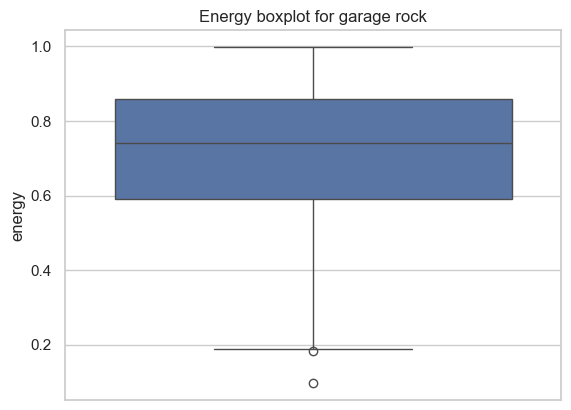

In [110]:
## Boxplot
# Whiskers -> 1.5*IQR + 75pct/25pct - 1.5*IQR
# Bottom/Top of box -> 25/75 pct
# Line -> Median
# Data outside is plotted as a circle -> Can be considered outlier
ax = sns.boxplot(garage)
ax.set_title("Energy boxplot for garage rock")
plt.show()

In [111]:
# Frequency table
binned = pd.cut(garage,10)
binned.value_counts()

energy
(0.728, 0.818]     194
(0.818, 0.908]     185
(0.638, 0.728]     152
(0.908, 0.998]     148
(0.548, 0.638]     113
(0.458, 0.548]      81
(0.367, 0.458]      68
(0.277, 0.367]      46
(0.187, 0.277]      11
(0.0963, 0.187]      2
Name: count, dtype: int64

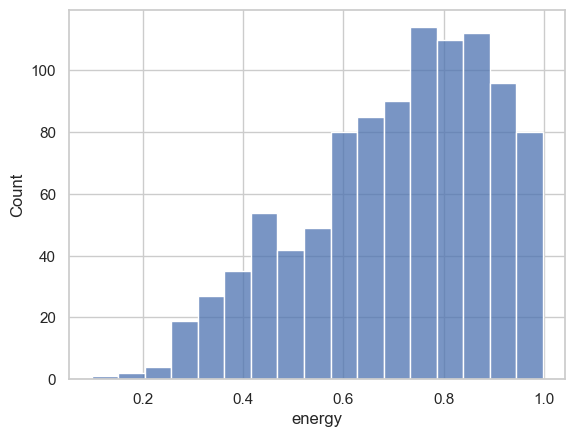

In [112]:
ax = sns.histplot(garage,)

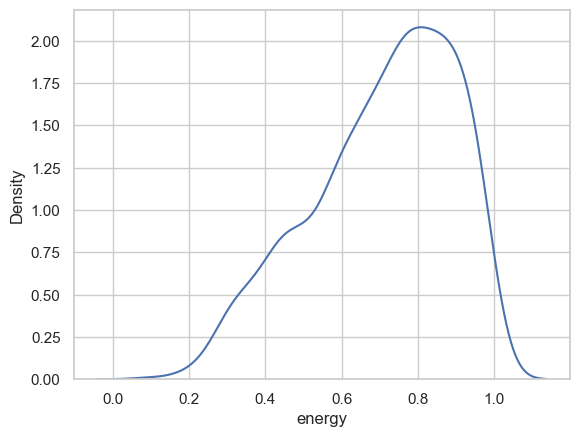

In [114]:
# Density plot -> Smoothed histogram. Normally computed using KDE -> Area inside curve is 1.
ax = sns.kdeplot(garage)

# Categorical Data

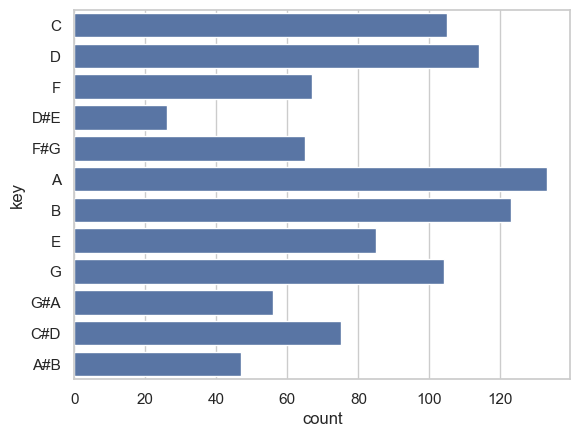

In [126]:
cat_target = 'key'
garage  = df[df['genre']=='garage'][cat_target].reset_index(drop=True)
_ = sns.countplot(garage)

In [128]:
# Mode -> Most common value
garage.mode()

0    A
Name: key, dtype: object

In [130]:
# "Probability"
garage.value_counts(normalize=True)

key
A      0.133
B      0.123
D      0.114
C      0.105
G      0.104
E      0.085
C#D    0.075
F      0.067
F#G    0.065
G#A    0.056
A#B    0.047
D#E    0.026
Name: proportion, dtype: float64

# CORRELATION

In [132]:
garage = df[df['genre']=='garage']
valence = garage['valence']
energy = garage['energy']

In [140]:
# Pearson correlation -> Multiple deviations from the mean from both variable, and normalize by the produt of the standard deviation -> Always between 1 and -1. Is linear. Sensitive to outliers
n = len(garage)
top_part = np.sum((valence - valence.mean())*(energy - energy.mean()))
bottom_part = (n-1) * valence.std() * energy.std()
top_part / bottom_part

0.2252574303705206

In [141]:
# Rank based statistics -> Better for smaller datasets and hypothesis testing.

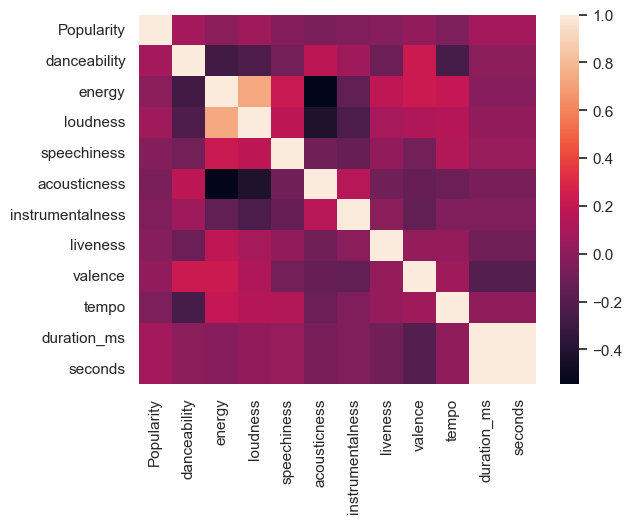

In [139]:
_ = sns.heatmap(garage.corr(numeric_only=True))

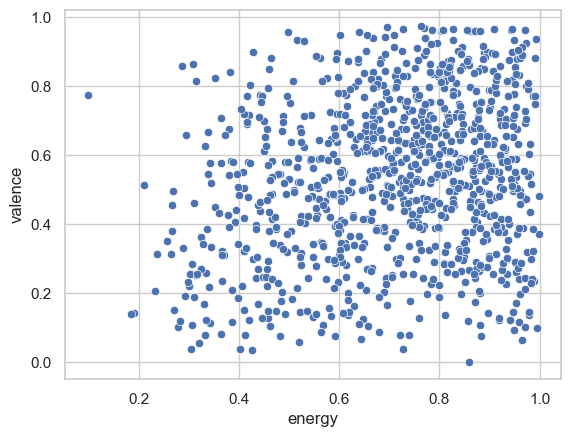

In [142]:
# Scatterplots
_ = sns.scatterplot(x=energy,y=valence)

# Two or more variables

## Two Numeric

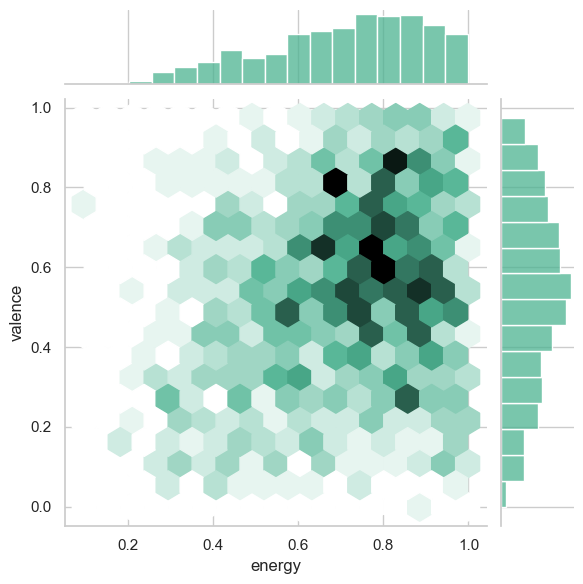

In [148]:
# Scatterplot are useful with few data points, too many gets harder to visualize
sns.jointplot(x=energy, y=valence, kind="hex", color="#4CB391")

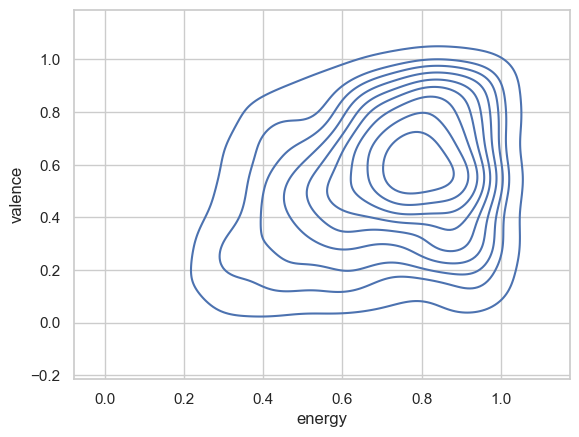

In [147]:
# Topographical map->Density increases near peak, around (0.6,0.8)
ax = sns.kdeplot(x=energy, y=valence)

## Two categorical

In [151]:
c1 = 'key'
c2 = 'mode'
key = garage[c1]
mode = garage[c2]

In [155]:
# Contigency table -> Normalize by rows
pd.crosstab(key,mode,normalize='index')

mode,Major,Minor
key,,
A,0.736842,0.263158
A#B,0.553191,0.446809
B,0.430894,0.569106
C,0.771429,0.228571
C#D,0.560000,0.440000
D,0.842105,0.157895
D#E,0.846154,0.153846
E,0.600000,0.400000
F,0.597015,0.402985


## Categorical and numeric

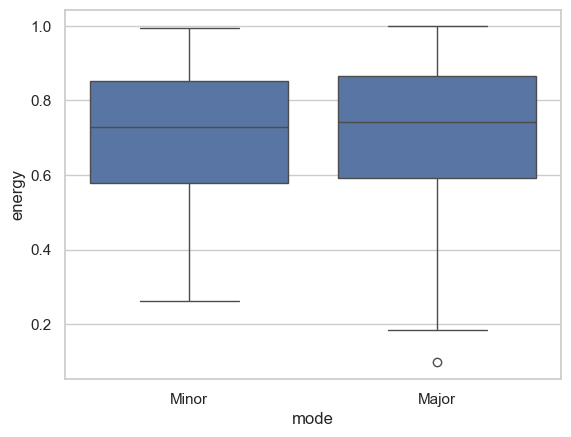

In [159]:
# Boxplot
_ = sns.boxplot(x='mode',y='energy',data=garage)

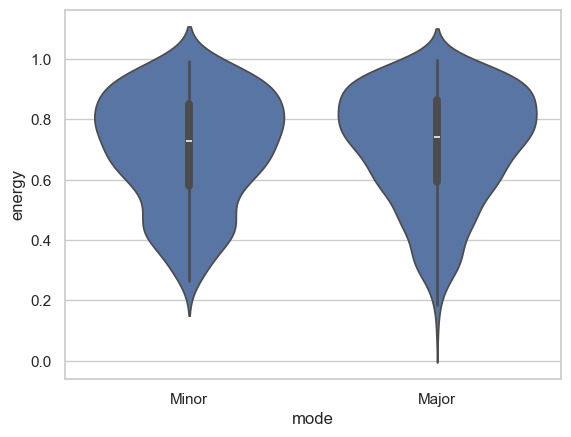

In [160]:
# Show nuances in distribution not visible in boxplot.
_ = sns.violinplot(x='mode',y='energy',data=garage)